# **Ф22**: Модуль моделирования социально-экономических эффектов реализации генерального плана

Сюда должен идти выход из Ф35, а именно `population` и `count_{service_type}`. В ином случае считаем из того, что есть (`base_scenario` или застройка юзера)

Берем кварталы `контекста` и `сценария`

In [19]:
import pandas as pd
import geopandas as gpd

SCENARIO_ID = 1392

blocks_gdf = pd.read_pickle('./data/blocks_f35.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')
dist_mx = pd.read_pickle('./data/dist_mx.pickle')
service_types_df = pd.read_pickle('./data/service_types.pickle')

P.S: если сценарий БАЗОВЫЙ, то нужно так же преобразовать столбцы, как в примере Ф35

In [20]:
# def generate_blocksnet_columns(blocks_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame) -> gpd.GeoDataFrame:
    
#     from typing import cast

#     st_df = service_types_df[~service_types_df.blocksnet.isna()].copy()
#     st_df['service_type_id'] = st_df.index
#     agg_df = st_df.groupby('blocksnet').agg({'service_type_id': lambda s : list(s)})
#     new_columns = {}
#     for st_name, row in agg_df.iterrows():
#         st_ids = row['service_type_id']
#         for prefix in ['count', 'capacity']:
#             sum_df = blocks_gdf[[f'{prefix}_{st_id}' for st_id in st_ids]].sum(axis=1)
#             new_columns[f'{prefix}_{st_name}'] = sum_df
#     new_columns_df = pd.DataFrame.from_dict(new_columns)
    
#     df = pd.concat([blocks_gdf, new_columns_df], axis=1)
#     return cast(gpd.GeoDataFrame, df)

# blocks_gdf = generate_blocksnet_columns(blocks_gdf, service_types_df)

## Маппинг типов сервисов для `social_indicators`

Там надо некоторым столбцам знать, к каким индикаторам они относятся, поэтому важно замапить

In [21]:
from blocksnet.analysis.indicators.socio_economic import SocialIndicator

SOCIAL_INDICATORS_MAPPING = {
    SocialIndicator.EXTRACURRICULAR: [23, 24],
    SocialIndicator.AMBULANCE: [39, 40],
    SocialIndicator.SPECIAL_MEDICAL: [41],
    SocialIndicator.PREVENTIVE_MEDICAL: [42],
    SocialIndicator.GYM: [68],
    SocialIndicator.ORPHANAGE: [46],
    SocialIndicator.SOCIAL_SERVICE_CENTER: [43],
    SocialIndicator.CULTURAL_CENTER: [49],
    SocialIndicator.CONCERT_HALL: [53],
    SocialIndicator.ICE_ARENA: [60],
    SocialIndicator.ECO_TRAIL: [72],
    SocialIndicator.FIRE_STATION: [79],
    SocialIndicator.TOURIST_BASE: [112],
}

def adapt_service_types_df(service_types_df : pd.DataFrame, mapping : dict[SocialIndicator, list[int]]) -> pd.DataFrame:
    service_types_df = service_types_df.copy()
    service_types_ids_mapping = {st_id:indicator for indicator, st_ids in mapping.items() for st_id in st_ids}
    service_types_df['indicator'] = service_types_df.index.map(service_types_ids_mapping)
    return service_types_df.rename(columns={
        'radius_availability_meters': 'meters',
        'time_availability_minutes': 'minutes',
        'services_per_1000_normative': 'count',
        'services_capacity_per_1000_normative': 'capacity'
    })

service_types_df = adapt_service_types_df(service_types_df, SOCIAL_INDICATORS_MAPPING)

In [22]:
service_types_df[service_types_df.blocksnet=='aeroway_terminal']

,capacity_modeled,infrastructure_type,weight,meters,minutes,count,capacity,soc_values_ids,blocksnet,indicator
service_type_id,,,,,,,,,,
82,10000.0,None,NaN,NaN,NaN,NaN,NaN,[5],aeroway_terminal,NaN


## Оценка показателей

Тут везде получаются `dict[Indicator : float]`, главное их потом разобрать

In [26]:
from blocksnet.analysis.indicators.socio_economic import calculate_general_indicators
from blocksnet.analysis.indicators.socio_economic import calculate_demographic_indicators
from blocksnet.analysis.indicators.socio_economic import calculate_transport_indicators
from blocksnet.analysis.indicators.socio_economic import calculate_engineering_indicators
from blocksnet.analysis.indicators.socio_economic import calculate_social_indicators

def calculate_indicators(blocks_gdf : gpd.GeoDataFrame, acc_mx : pd.DataFrame, dist_mx : pd.DataFrame, roads_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame):
    roads_gdf = roads_gdf.to_crs(blocks_gdf.crs)
    roads_gdf = roads_gdf.overlay(blocks_gdf)
    
    general_indicators = calculate_general_indicators(blocks_gdf)
    demographic_indicators = calculate_demographic_indicators(blocks_gdf)
    transport_indicators = calculate_transport_indicators(blocks_gdf, acc_mx, roads_gdf)
    engineering_indicators = calculate_engineering_indicators(blocks_gdf)
    sc_indicators, sp_indicators = calculate_social_indicators(blocks_gdf, acc_mx, dist_mx, service_types_df)

    return pd.concat([
        general_indicators, 
        demographic_indicators, 
        transport_indicators, 
        engineering_indicators, 
        sc_indicators, 
        sp_indicators
    ])

Важно получить слой с дорогами

<Axes: >

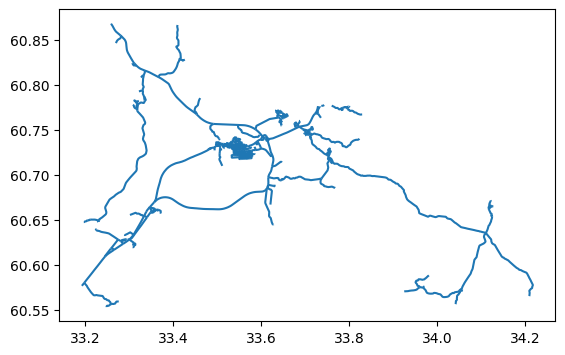

In [27]:
from prostor.fetchers import context

ROADS_POF_ID = 26

roads_gdf = context.get_physical_objects(SCENARIO_ID, physical_object_function_id=ROADS_POF_ID)

roads_gdf.plot()

Просто отдаем и всё, само разберется по `parent_id`

In [29]:
indicators_df = calculate_indicators(blocks_gdf, acc_mx, dist_mx, roads_gdf, service_types_df)

/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 595 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
100%|██████████| 39/39 [00:01<00:00, 22.51it/s]


In [ ]:
indicators_df

## Результат

Тут главное просто всё замапить..

In [34]:
from blocksnet.analysis.indicators.socio_economic import GeneralIndicator, DemographicIndicator, TransportIndicator, EngineeringIndicator, SocialCountIndicator, SocialProvisionIndicator

INDICATORS_MAPPING = {
    GeneralIndicator.AREA : 1,
    GeneralIndicator.URBANIZATION : 123,
    SocialCountIndicator.BANK : 246,
    ...: ...
}

def get_values(indicators_df : pd.DataFrame) -> list[dict[str, float]]:
    result = []
    for indicator in indicators_df.index:
        indicator_id = INDICATORS_MAPPING.get(indicator)
        for territory_id in indicators_df.columns:
            if territory_id == 'total':
                continue # пропускаем колонку которая за ВСЮЮЮ территорию отвечает
            value = indicators_df.loc[indicator, territory_id]
            result.append({
                'territory_id': int(territory_id),
                'indicator_id': indicator_id,
                'value': value
            })
    return result

values = get_values(indicators_df)

In [35]:
values

[{'territory_id': 117,
  'indicator_id': 1,
  'value': np.float64(708.4401703239722)},
 {'territory_id': 121,
  'indicator_id': 1,
  'value': np.float64(1088.2775229123965)},
 {'territory_id': 117,
  'indicator_id': 123,
  'value': np.float64(0.005647870683738194)},
 {'territory_id': 121, 'indicator_id': 123, 'value': np.float64(0.0)},
 {'territory_id': 117, 'indicator_id': None, 'value': np.float64(14862.0)},
 {'territory_id': 121, 'indicator_id': None, 'value': np.float64(279.0)},
 {'territory_id': 117,
  'indicator_id': None,
  'value': np.float64(20.978482901673342)},
 {'territory_id': 121,
  'indicator_id': None,
  'value': np.float64(0.25636843004287496)},
 {'territory_id': 117,
  'indicator_id': None,
  'value': np.float64(0.2698578875514956)},
 {'territory_id': 121,
  'indicator_id': None,
  'value': np.float64(0.1805874166616252)},
 {'territory_id': 117,
  'indicator_id': None,
  'value': np.float64(0.25800901838362816)},
 {'territory_id': 121, 'indicator_id': None, 'value': n